# GRPC Inference

### Setup

In [1]:
!pip list | grep -e grpcio -e protobuf

grpcio                          1.56.0
grpcio-tools                    1.33.2
protobuf                        3.20.3

[notice] A new release of pip available: 22.2.2 -> 23.2.1
[notice] To update, run: pip install --upgrade pip


In [2]:
!pip install grpcio==1.56.0 grpcio-tools==1.33.2 protobuf==3.20.3


[notice] A new release of pip available: 22.2.2 -> 23.2.1
[notice] To update, run: pip install --upgrade pip


In [3]:
!pip list | grep -e grpcio -e protobuf

grpcio                          1.56.0
grpcio-tools                    1.33.2
protobuf                        3.20.3

[notice] A new release of pip available: 22.2.2 -> 23.2.1
[notice] To update, run: pip install --upgrade pip


In [4]:
grpc_host = 'modelmesh-serving'
grpc_port = 8033

textencoder_model_name = 'textencoder'
unet_model_name = 'unet'
vaeencoder_model_name = 'vaeencoder'
vaedecoder_model_name = 'vaedecoder'

### Inspecting the gRPC Endpoint

Let's check out the gRPC endpoint's model metadata.

In [5]:
import grpc
import grpc_predict_v2_pb2
import grpc_predict_v2_pb2_grpc


channel = grpc.insecure_channel(f"{grpc_host}:{grpc_port}")
stub = grpc_predict_v2_pb2_grpc.GRPCInferenceServiceStub(channel)

# request = grpc_predict_v2_pb2.ModelMetadataRequest(name=vaeencoder_model_name)
# response = stub.ModelMetadata(request)
# print(response)

request = grpc_predict_v2_pb2.ModelMetadataRequest(name=vaedecoder_model_name)
response = stub.ModelMetadata(request)
print(response)


name: "vaedecoder__isvc-98a4141f93"
versions: "1"
platform: "onnxruntime_onnx"
inputs {
  name: "latent_sample"
  datatype: "FP32"
  shape: -1
  shape: -1
  shape: -1
  shape: -1
}
outputs {
  name: "sample"
  datatype: "FP32"
  shape: -1
  shape: -1
  shape: -1
  shape: -1
}



### Request Function

Builds and submits our gRPC request.

In [6]:
import torch

def vae_decoder_grpc_request(latent_sample):
    inputs = []
    inputs.append(grpc_predict_v2_pb2.ModelInferRequest().InferInputTensor())
    inputs[0].name = "latent_sample"
    inputs[0].datatype = "FP32"
    inputs[0].shape.extend([1, 4, 64, 64])
    arr = latent_sample.flatten()
    inputs[0].contents.fp32_contents.extend(arr)

    request = grpc_predict_v2_pb2.ModelInferRequest()
    request.model_name = vaedecoder_model_name
    request.inputs.extend(inputs)

    response = stub.ModelInfer(request)
    out_sample = np.frombuffer(response.raw_output_contents[0], dtype=np.float32)
    
    print(out_sample.dtype)
    print(out_sample.shape)
    print(out_sample)
    # return torch.tensor(out_sample)   

    return torch.tensor(out_sample.reshape([1, 3, 512, 512]))

### Run the Request

In [7]:
import numpy as np
import torch

from IPython.display import Image

latents = np.load("latents.npy")
print(latents.dtype)
print(latents.shape)
print(latents)


float32
(1, 4, 64, 64)
[[[[-4.881512   -4.4344816  -2.9175892  ... -4.8503914   6.7518983
    -6.7196684 ]
   [-2.1946423   1.1995759   1.73766    ...  0.70919037  4.705099
     5.0520253 ]
   [-3.7168941  -2.653243   -3.8779795  ... -3.429516   -3.3315213
    -2.7346654 ]
   ...
   [-4.5876904  -2.4774644  -8.893459   ... -6.8858624  -2.7285159
    -2.1134152 ]
   [-1.7194629  -3.5185263  -6.354595   ... -2.537158   -3.1306996
    -1.756837  ]
   [-3.3765178  -6.5538692  -6.1412497  ... -8.147389   -6.37208
    -3.9051726 ]]

  [[ 0.48421198 -1.6678833  -2.6453536  ... -0.41001058 -0.6802998
     3.6029916 ]
   [-3.6023483  -4.2129993  -4.5272536  ...  1.3379602   1.7459804
     5.4142566 ]
   [-0.32695    -1.9024178   1.3020631  ... -2.4018557  -5.084688
    -1.6598971 ]
   ...
   [-7.0198255  -0.4659118  -2.7677252  ... -1.4450792  -4.833279
    -1.2843065 ]
   [-7.767404   -0.8404074  -0.13150036 ... -2.4248078  -1.8617383
    -1.351738  ]
   [-4.556972   -0.37134716 -3.3059945  ..

In [8]:
import torch
import numpy as np


image_tensor = vae_decoder_grpc_request(latents)

float32
(786432,)
[-0.3173435  -0.34452614 -0.36878794 ... -0.62190443 -0.64395255
 -0.6387428 ]


In [9]:
print(image_tensor.dtype)
print(image_tensor.shape)
print(image_tensor)

torch.float32
torch.Size([1, 3, 512, 512])
tensor([[[[-0.3173, -0.3445, -0.3688,  ...,  0.0239,  0.0151,  0.0326],
          [-0.3611, -0.3361, -0.3356,  ...,  0.0109,  0.0063,  0.0073],
          [-0.3778, -0.3706, -0.3606,  ...,  0.0303,  0.0273,  0.0321],
          ...,
          [-0.7477, -0.7097, -0.6979,  ..., -0.5256, -0.5544, -0.5595],
          [-0.7241, -0.7481, -0.7305,  ..., -0.5195, -0.5173, -0.5336],
          [-0.7457, -0.7165, -0.7278,  ..., -0.5144, -0.5091, -0.5218]],

         [[-0.2356, -0.2396, -0.2659,  ...,  0.1765,  0.1969,  0.1777],
          [-0.2439, -0.2117, -0.2105,  ...,  0.1571,  0.1669,  0.1845],
          [-0.2572, -0.2489, -0.2384,  ...,  0.1695,  0.1750,  0.1818],
          ...,
          [-0.7095, -0.6659, -0.6353,  ..., -0.4759, -0.4987, -0.4727],
          [-0.6659, -0.6849, -0.6541,  ..., -0.4757, -0.4653, -0.4769],
          [-0.7150, -0.6717, -0.6664,  ..., -0.4722, -0.4693, -0.4838]],

         [[-0.2750, -0.2888, -0.3079,  ...,  0.1967,  0.218

In [11]:
print(image_tensor.dtype)
print(image_tensor.shape)
print(image_tensor)

torch.float32
torch.Size([1, 3, 512, 512])
tensor([[[[-0.3173, -0.3445, -0.3688,  ...,  0.0239,  0.0151,  0.0326],
          [-0.3611, -0.3361, -0.3356,  ...,  0.0109,  0.0063,  0.0073],
          [-0.3778, -0.3706, -0.3606,  ...,  0.0303,  0.0273,  0.0321],
          ...,
          [-0.7477, -0.7097, -0.6979,  ..., -0.5256, -0.5544, -0.5595],
          [-0.7241, -0.7481, -0.7305,  ..., -0.5195, -0.5173, -0.5336],
          [-0.7457, -0.7165, -0.7278,  ..., -0.5144, -0.5091, -0.5218]],

         [[-0.2356, -0.2396, -0.2659,  ...,  0.1765,  0.1969,  0.1777],
          [-0.2439, -0.2117, -0.2105,  ...,  0.1571,  0.1669,  0.1845],
          [-0.2572, -0.2489, -0.2384,  ...,  0.1695,  0.1750,  0.1818],
          ...,
          [-0.7095, -0.6659, -0.6353,  ..., -0.4759, -0.4987, -0.4727],
          [-0.6659, -0.6849, -0.6541,  ..., -0.4757, -0.4653, -0.4769],
          [-0.7150, -0.6717, -0.6664,  ..., -0.4722, -0.4693, -0.4838]],

         [[-0.2750, -0.2888, -0.3079,  ...,  0.1967,  0.218

In [12]:
from PIL import Image

def image_to_pil(image_tensor):    
    image = (image_tensor / 2 + 0.5).clamp(0, 1).squeeze()
    image = (image.permute(1, 2, 0) * 255).to(torch.uint8).cpu().numpy()
    images = (image * 255).round().astype("uint8")
    image = Image.fromarray(image)
    return image

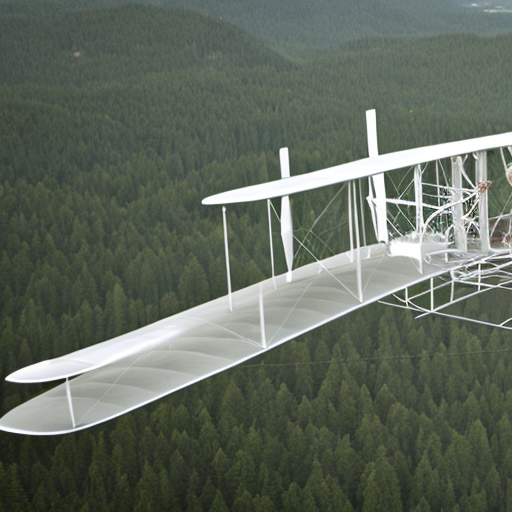

In [13]:
image = (image_tensor / 2 + 0.5).clamp(0, 1).squeeze()
image = (image.permute(1, 2, 0) * 255).to(torch.uint8).cpu().numpy()
images = (image * 255).round().astype("uint8")
image = Image.fromarray(image)
image

In [14]:
img = image_to_pil(image_tensor)

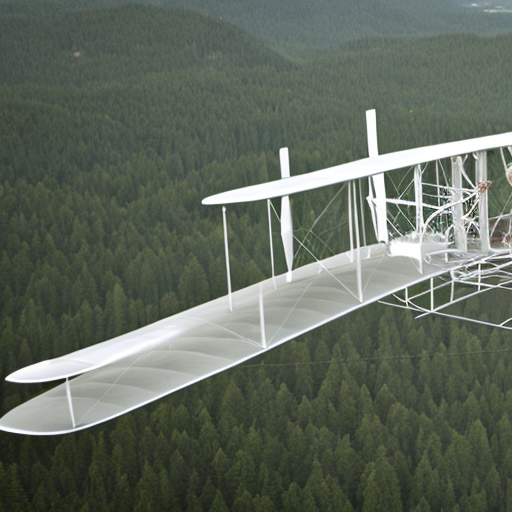

In [ ]:
img